### 데이터 명세

- id : 해당 데이터의 고유한 ID (train, test와의 중복은 없음)

- date  : 날짜

- bus_route_id : 노선 id

- in_out  : 시내버스, 시외버스 구분 (categorical)

- station_code : 해당 승하차 정류소의 ID

- station_name : 해당 승하차 정류소의 이름

- latitude : 해당 버스 정류장의 위도 

- longitude : 해당 버스 정류장의 경도 

### *** 같은 위도경도여도 진행 방향에 따라 정류장이 다를수 있음.

- X-Y ride : 00:00부터 59:59까지 승차한 인원수

- X-Y takeoff : 00:00부터 59:59까지 하차한 인원수

- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재, 예측해야할 target) 


In [44]:
import pandas as pd
import numpy as np

In [45]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [46]:
df_bus = pd.read_csv('../../data/bus_bts.csv')
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')

df_bus.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


#### 결측치 확인

In [47]:
print(train.isnull().sum())#train 결측값 개수 확인 
print("-----------------------------")
print(test.isnull().sum()) #train 결측값 개수 확인 

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64
-----------------------------
id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64


구해야 하는 시간대 : 18~20시

train과 test에 나와있는 시간별 data를 2시간 간격으로 조정

In [48]:
train['68_on']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810_on']=train['8~9_ride']+train['9~10_ride']
train['1012_on']=train['10~11_ride']+train['11~12_ride']

train['68_off']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810_off']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012_off']=train['10~11_takeoff']+train['11~12_takeoff']

train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,68_on,810_on,1012_on,68_off,810_off,1012_off
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 시간대별 geton과 getoff 들의 상관성 확인

상관성이 생각보다 높게 나왔다.

Text(0.5, 1.0, 'arrive and leave correlation graph')

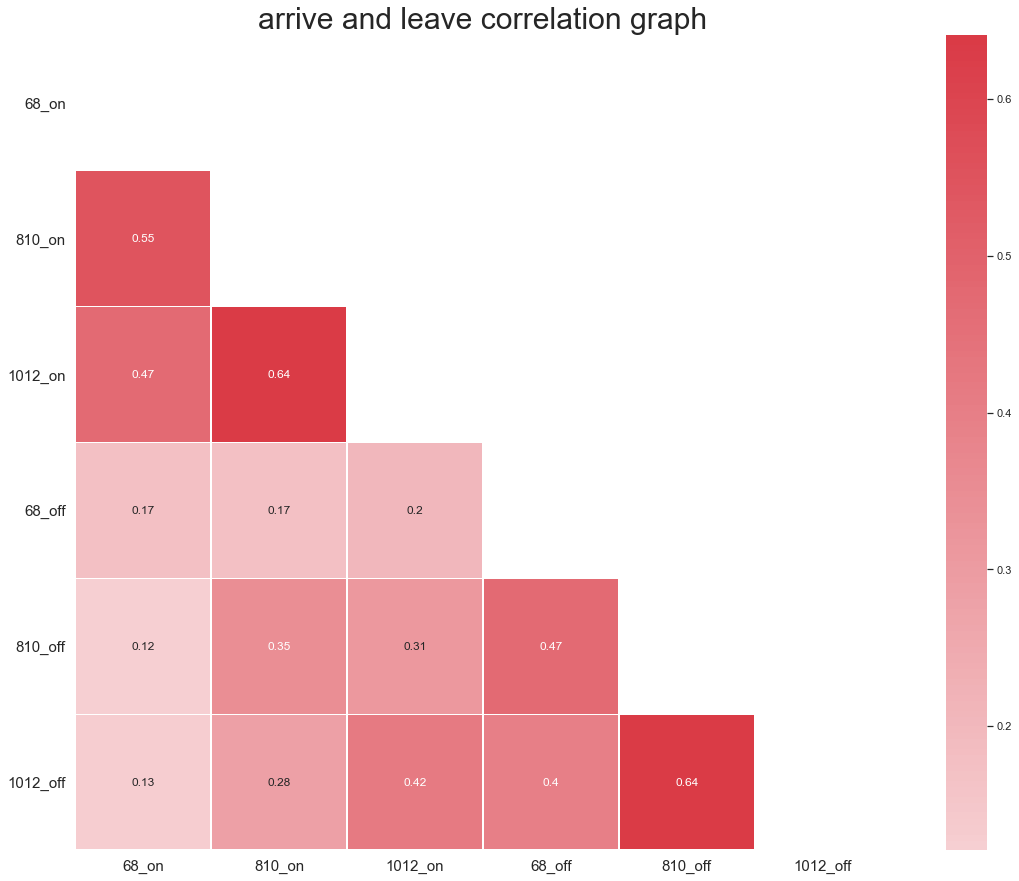

In [49]:
import seaborn as sns #시각화
import matplotlib.pyplot as plt # 시각화

train_onoff = train[['68_on', '810_on', '1012_on', '68_off', '810_off', '1012_off']]

cor = train_onoff.corr()

sns.set(style="white")
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(200, 10, as_cmap=True)


# 히트맵 생성
sns.heatmap(cor, mask=mask, cmap = cmap, center = 0, square=True, linewidths=0.5, cbar_kws={'shrink':1}, annot = True)

plt.xticks(size = 15)
plt.yticks(size = 15, rotation= 0)
plt.title("arrive and leave correlation graph", size = 30)

In [50]:
test['68_on']=test['6~7_ride']+test['7~8_ride'] # 6 ~ 8시 승차인원
test['810_on']=test['8~9_ride']+test['9~10_ride']
test['1012_on']=test['10~11_ride']+test['11~12_ride']

test['68_off']=test['6~7_takeoff']+test['7~8_takeoff'] # 6 ~ 8시 하차인원
test['810_off']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012_off']=test['10~11_takeoff']+test['11~12_takeoff']

test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,68_on,810_on,1012_on,68_off,810_off,1012_off
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,9.0,10.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,19.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,3.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,26.0,46.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### target = 18~20

train에서 확인

확인 결과 : 18~20 ride밖에 없고 takeoff는 없음... 그냥 이용량만 보면 돼서 그런가..?

In [51]:
train['18~20_ride'].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
5.0        5911
6.0        4291
7.0        3152
8.0        2288
9.0        1865
10.0       1409
11.0       1183
12.0        996
13.0        807
14.0        660
15.0        597
16.0        508
17.0        450
18.0        408
19.0        394
20.0        331
21.0        261
22.0        234
23.0        218
24.0        198
25.0        168
26.0        194
27.0        150
28.0        144
29.0        132
30.0        113
31.0         94
32.0         80
33.0         79
34.0         77
35.0         78
36.0         58
37.0         61
38.0         64
39.0         53
40.0         37
41.0         51
42.0         43
43.0         41
44.0         52
45.0         37
46.0         32
47.0         35
48.0         21
49.0         28
50.0         26
51.0         24
52.0         21
53.0         24
54.0         22
55.0         22
56.0         20
57.0         17
58.0         21
59.0         13
60.0         16
61.0         20
62.0    

In [52]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', '68_on', '810_on', '1012_on', '68_off', '810_off',
       '1012_off'],
      dtype='object')

# df_bus 데리고 놀기

In [53]:
df_bus.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [54]:
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_card_id         float64
 1   bus_route_id         int64  
 2   vhc_id               int64  
 3   geton_date           object 
 4   geton_time           object 
 5   geton_station_code   int64  
 6   geton_station_name   object 
 7   getoff_date          object 
 8   getoff_time          object 
 9   getoff_station_code  float64
 10  getoff_station_name  object 
 11  user_category        int64  
 12  user_count           int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


In [55]:
df_bus.size

31322382

In [56]:
df_bus.user_card_id = df_bus.user_card_id.astype('object')
df_bus.bus_route_id = df_bus.bus_route_id.astype('object')
df_bus.vhc_id = df_bus.vhc_id.astype('object')
df_bus.geton_station_code = df_bus.geton_station_code.astype('object')
df_bus.getoff_station_code = df_bus.getoff_station_code.astype('object')

## user_category - 시각화해보기

승객 구분 

01-일반

02-어린이

04-청소년

06-경로

27-장애 일반

28-장애 동반

29-유공 일반

30-유공 동반)

In [57]:
df_bus.groupby(['user_category', ]).size()

user_category
1     1463495
2       36526
4      279779
6      473325
27      73042
28      67913
29      15243
30         91
dtype: int64

## date

df_bus 의 날짜 : 2019-09-01 ~ 2019-10-16

-> train data와 일치한다.

7일 간격으로 버스 이용량이 크게 하락하는 경향 존재함.

9월에는 7일 간격이었는데, 10월 초반에는 3~4일 간격인 것을 발견.

7일 간격이 무너진 것이 아니라, 중간 중간의 날짜에 공휴일이 있는 것은 아닐까? 맞음.

orange = weekends

red = holidays

In [58]:
date_arr = np.sort(df_bus.geton_date.unique())

date_arr

array(['2019-09-01', '2019-09-02', '2019-09-03', '2019-09-04',
       '2019-09-05', '2019-09-06', '2019-09-07', '2019-09-08',
       '2019-09-09', '2019-09-10', '2019-09-11', '2019-09-12',
       '2019-09-13', '2019-09-14', '2019-09-15', '2019-09-16',
       '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
       '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24',
       '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-28',
       '2019-09-29', '2019-09-30', '2019-10-01', '2019-10-02',
       '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06',
       '2019-10-07', '2019-10-08', '2019-10-09', '2019-10-10',
       '2019-10-11', '2019-10-12', '2019-10-13', '2019-10-14',
       '2019-10-15', '2019-10-16'], dtype=object)

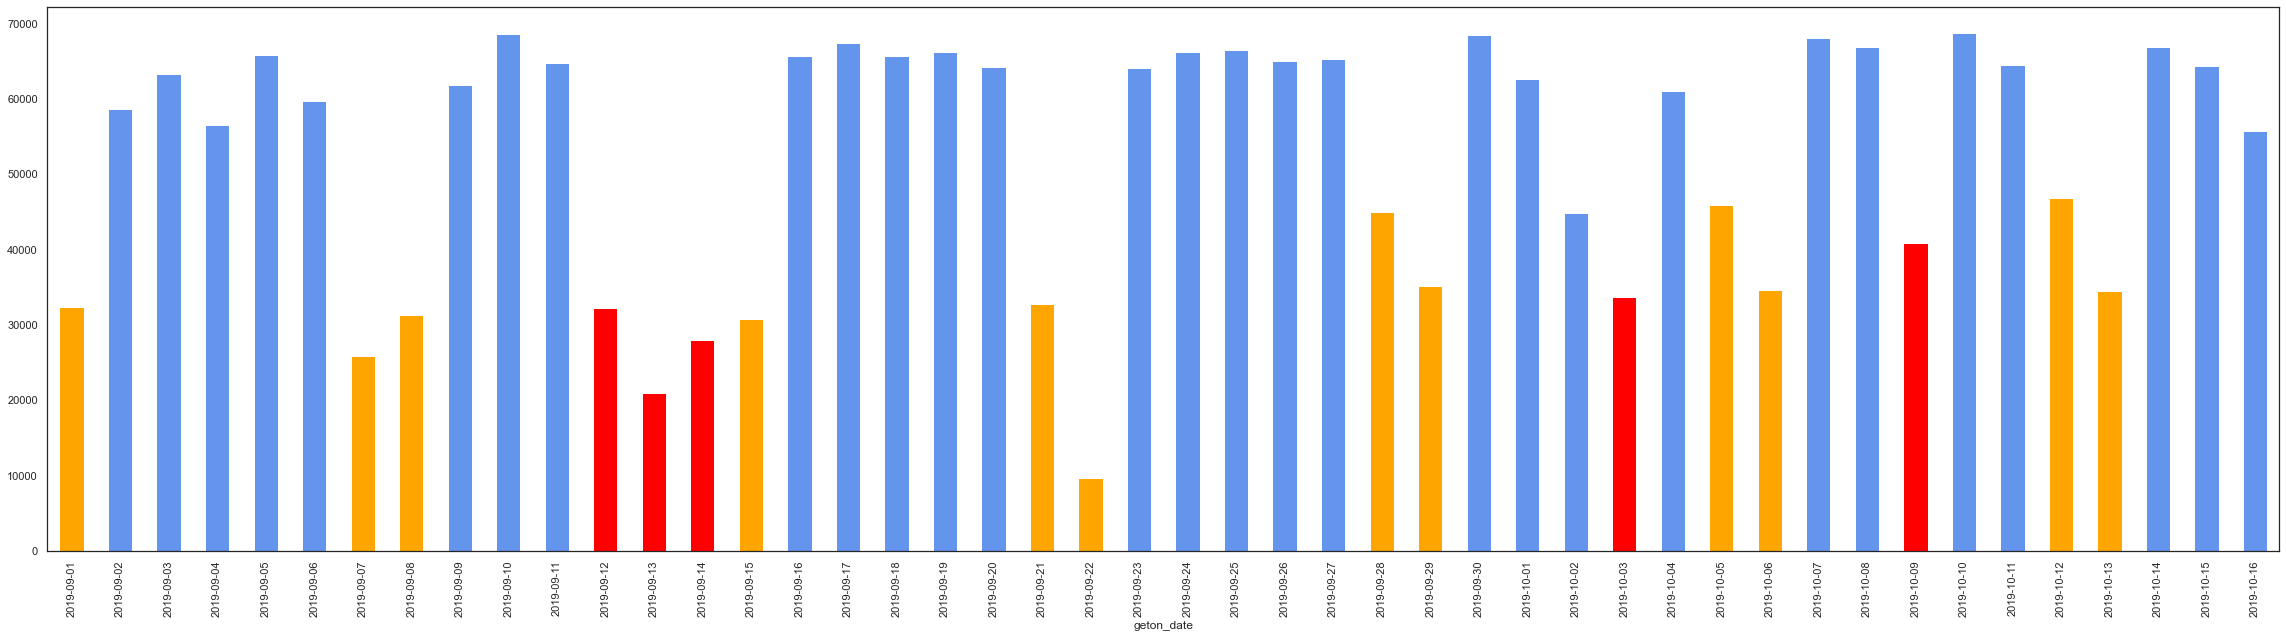

In [59]:
weekends = ['2019-09-01', '2019-09-07', '2019-09-08', '2019-09-15', '2019-09-21', '2019-09-22',
            '2019-09-28', '2019-09-29',  '2019-10-05', '2019-10-06', '2019-10-12', '2019-10-13']

holidays = ['2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09']

f, axes = plt.subplots(1, 1, figsize=(40, 10), sharex=True)


groups = df_bus.groupby('geton_date').size()


clrs = ['red' if (x  in holidays) else ('orange' if (x in weekends) else 'cornflowerblue') for x in groups.keys() ]
groups.plot.bar(color = clrs)


## bus_bts 에서 geton 정류장을 확인하고 날짜별로 groupby? 해서 train data와 맞는지 여부 보기



## 확률밀도함수로 시간 data 합쳐서 2시간 간격 data로 모아보기

In [60]:
df_bus.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.01001e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592,화북초등학교,1,1
1,1.01001e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273,고산동산(광양방면),1,1
2,1.01916e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431,정존마을,4,1
3,1.01915e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431,정존마을,1,1
4,1.01001e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972,제주국제공항(종점),4,1


In [68]:
df_bus['geton_hour'] = df_bus['geton_time']
for i in range(31322382):
    x = df_bus['geton_time'][i][0:2]
    df_bus['geton_hour'][i]=x

df_bus.head(20)

<ipython-input-68-14b8577e5f6d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bus['geton_hour'][i]=x


KeyboardInterrupt: 

## train data로 승차 추이 보기 - busbts랑 비교

## 날씨 data랑 연관지어보기

## 출근시간 data는 line 그래프로 하고, 그 위에 18-20 ride data를 일직선으로 표시해서 연관성 보기